In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Input,GRU
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping

def build_model(application,model_layer):
    # Load the model
    base_model = application(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    # Make the base model non-trainable
    for layer in base_model.layers:
        layer.trainable = False

    # Define the input shape for our final model
    # The shape should be (num_frames, height, width, channels)
    # Replace num_frames with the number of frames in our video data
    input_shape = (16, 64,64, 3)
    model_input = Input(shape=input_shape)

    # Add a TimeDistributed wrapper to handle the time dimension in the video data
    x = TimeDistributed(base_model)(model_input)

    # Flatten the output
    x = TimeDistributed(Flatten())(x)

    # Add an LSTM layer to handle the sequence of features extracted from the frames
    x = model_layer(256)(x)

    # Add a Dense layer for binary classification
    output = Dense(2, activation='softmax')(x)
    return Model(inputs=model_input, outputs=output)


In [2]:
from google.colab import drive
drive.mount('/content/drive')  # Mount the entire Google Drive


Mounted at /content/drive


In [3]:
file_path = "/content/drive/My Drive/features_Own.npy"
!cp "/content/drive/My Drive/features_Own.npy" /content/


In [6]:
features,labels=np.load("/content/features_Own.npy"),np.load("/content/labels_Own.npy")

In [7]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.2,
                                                                            shuffle=True, random_state=42)

In [8]:
# Create a new model
vgg16_model = build_model(VGG16,LSTM)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.6,patience=5,min_lr=0.00005,verbose=1)

# Compiling the model
vgg16_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])

# Fitting the model
history = vgg16_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 10 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.5728 - loss: 0.7111 - val_accuracy: 0.6313 - val_loss: 0.6281 - learning_rate: 0.0100
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - accuracy: 0.6966 - loss: 0.5765 - val_accuracy: 0.7031 - val_loss: 0.5309 - learning_rate: 0.0100
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.7423 - loss: 0.4984 - val_accuracy: 0.7750 - val_loss: 0.4810 - learning_rate: 0.0100
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.7530 - loss: 0.5059 - val_accuracy: 0.6938 - val_loss: 0.5616 - learning_rate: 0.0100
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.7603 - loss: 0.4770 - val_accuracy: 0.8000 - val_loss: 0.4431 - learning_rate: 0.0100
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.8049 - loss: 0.4313 - val_accuracy: 0.6687 - val_loss: 0.6701 - learning_rate: 0.0100
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.7


Classification Report of VGG16:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       199
           1       0.85      0.95      0.89       201

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400


Confusion Matrix of VGG16:


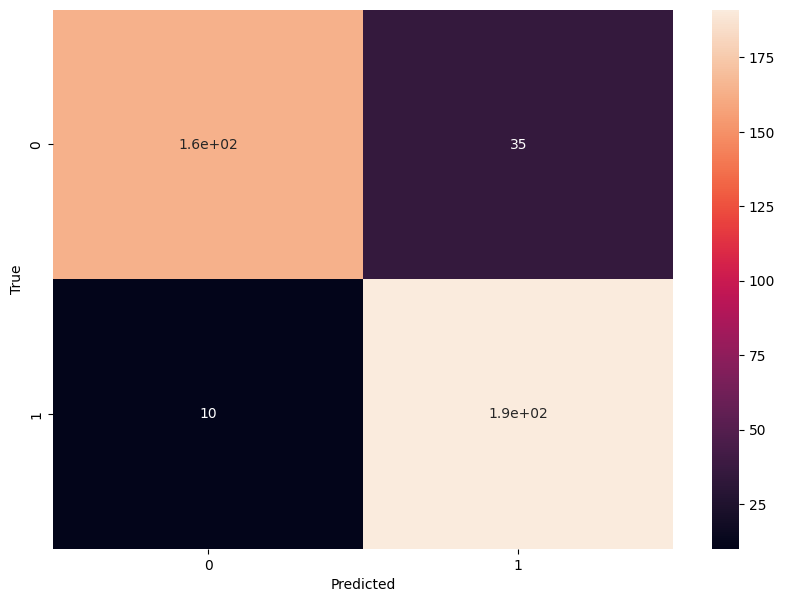

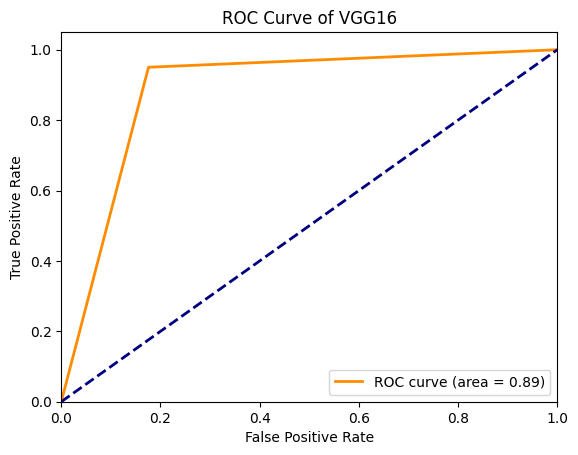

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `predicted_labels` are the predictions of model on the test set
predicted_labels = []
batch_size = 8  # Further reduce this value based on GPU's memory
for i in range(0, features_test.shape[0], batch_size):
    batch_predictions = vgg16_model.predict(features_test[i:i+batch_size], verbose=0)
    batch_predictions = np.argmax(batch_predictions, axis=1)
    predicted_labels.extend(batch_predictions)

predicted_labels = np.array(predicted_labels)
true_labels = np.argmax(labels_test, axis=1)

# Classification Report
print("\nClassification Report of VGG16:")
print(classification_report(true_labels, predicted_labels))

# Confusion Matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix of VGG16:")
# print(conf_mat)

# Heatmap for Confusion Matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of VGG16')
plt.legend(loc="lower right")
plt.show()

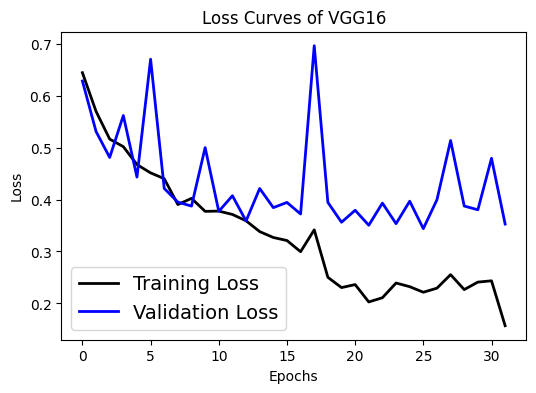

In [11]:
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves of VGG16', fontsize=12)
plt.show()

In [13]:
vgg16_model.save('/content/vgg16_model.h5')  # Save as an HDF5 file


In [14]:
from google.colab import files
files.download('/content/vgg16_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>